In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [10]:
directory = 'data/Respiratory_Sound_Database/audio_and_txt_files'
dataset = []
        
sample_rate = 4000
mfcc_size = 13 # size 12-13 is able to capture most of the desired information in terms of variance where values larger than 13 do not add much more information and values smaller than 12 do not capture enough information

for file in os.listdir(directory):
    
    if file.endswith('.wav'):
        file_path = os.path.join(directory, file)

        data, _ = librosa.load(file_path)

        trimmed_data, _ = librosa.effects.trim(y=data)

        mfccs = librosa.feature.mfcc(y=trimmed_data, 
                                        sr=sample_rate, 
                                        n_mfcc=mfcc_size)

        stddev_mfccs = np.std(mfccs, axis=1)

        mean_mfccs = np.mean(mfccs, axis=1)

        average_difference = np.zeros((mfcc_size,))
        for i in range(0, len(mfccs.T) - 2, 2):
            average_difference += mfccs.T[i] - mfccs.T[i+1]
        average_difference /= (len(mfccs) // 2)   
        average_difference = np.array(average_difference)

        concat_features = np.hstack((stddev_mfccs, mean_mfccs))
        concat_features = np.hstack((concat_features, average_difference))
        
        dataset += [(file, concat_features)]

In [12]:
all_file_paths, mfcc_features = zip(*dataset)
    
mfcc_features = np.array(mfcc_features)

mfcc_tuples = []

all_json = dict()
all_json["filenames"] = all_file_paths

print(len(all_file_paths), 
      mfcc_features.shape)

920 (920, 6)


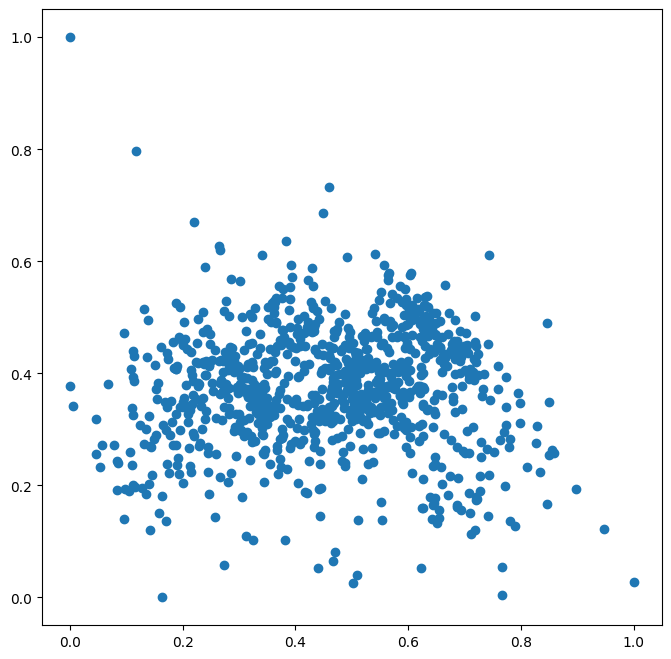

In [16]:
def transform_numpy_to_json(array):
    data = []
    for position in array:
        data.append({
            'coordinates': position.tolist()
        })
    return data

def get_pca(features):
    if features.shape[1] == 2: # if the mfcc_features already has dimensionality 2, we can optionally skip PCA and just scale the data as implementing PCA will not affect the output
        scaler = MinMaxScaler()
        return scaler.fit(features)
    else:
        pca = PCA(n_components=2)
        transformed = pca.fit(features).transform(features)
        scaler = MinMaxScaler()
        scaler.fit(transformed)
        return scaler.transform(transformed)

pca_mfcc = get_pca(mfcc_features)

mfcc_key = 'pcamfcc'

all_json[mfcc_key] = transform_numpy_to_json(pca_mfcc)
plt.figure(figsize=(8, 8))
_ = plt.scatter(pca_mfcc.T[0],
                pca_mfcc.T[1])
plt.show()